# Aprendizaje Automático

## Proyecto

Profesor: MSc. Felipe Meza.

Instituto Tecnológico de Costa Rica, 

Medio de entrega: TecDigital.

Entregables: El entregable consiste en el url de la notebook Proyecto.ipynb en GITHUB. 

Grupo de trabajo:
- Manuel Calderón
- Ernesto Rivera

---
Objetivo: El objetivo del Proyecto consiste en hacer un análisis de un conjunto de datos.

# Manejo y preprocesado de datos


Para este proyecto se aplicara un analisis de inventarios dividiendo las entradas y salidas, aplicando una prediccion de las necesidades de productos, dichos analisis seran por producto dado a que cada uno de estos tienen movimientos muy diferentes entre ellos, dado a las necesidaes de los clientes.

Para este proyecto se aplicarán las predicciones usando una red neuronal, aplicado a los miviemientos de producto día a día, por lo que se debe aplicar un analisis de movimientos con series de tiempo. 

Dado al funcionamiento de las series de tiempo se manejará solo la columna de cantidades, pero se debe crear un ordenamiento por fechas para el proceso, luego hacer la separacion de los datos X, Y con X los datos a analizar y el Y los datos con un salto de tiempo.

El proyecto contaŕa con las siguientes partes:
- Importación de bibliotecas.
- Creación y explicación de métodos auxiliares.
- Carga y procesado de datos.
- Analisis de datos separado entre entradas y salidas

### Importar bibliotecas

In [1]:
import numpy as np
import pandas as pd
import math
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt
%matplotlib inline

### Creación de métodos auxiliares
Las siguientes celdas contienen funciones de:
- agrupamiento de datos,
- reorganización de datos en variables,
- creación del modelo de red neuronal,
- o para graficar.

**Agrupamiento de datos**

Dada la complejidad de los datos dado que son demasiados registos diarios y demasiado variado (las entradas y salidas de productos son muy variados día a día), se aplicó una agrupación por mes y así realiza un análisis y predicción mensual.

Además, dado que la data fluctúa entte negativos en salidas y positivos por entradas, se aplicó una separación sobre estos y poder aplicar dos análisis por producto.

In [2]:
## Toma los valores del dataframe y los agrupa por producto
## y por fecha
## sumando las cantidades.
## Salida:  dos DataFrames: entradas, salidas de inventiario
def agruparCantidadPorProducto(df):
    dataEntradas = {}
    dataSalidas = {}
    for index, row in df.iterrows():
        name = row['Producto/Nombre'] + str(row['Creado en'])
        data = dataEntradas if row['Cantidad'] >= 0 else dataSalidas
        if not name in data:
            data.update({name:{'Creado en': row['Creado en'], 
                               'Producto/Nombre': row['Producto/Nombre'],
                               'Cantidad': row['Cantidad']}})
        else:
            data[name].update({'Cantidad': row['Cantidad'] + data[name]['Cantidad']})

    listEntradas, listSalidas = [],[]
    for ind in dataEntradas:
        listEntradas.append(dataEntradas[ind])
    for ind in dataSalidas:
        listSalidas.append(dataSalidas[ind])
    
    return pd.DataFrame(listEntradas), pd.DataFrame(listSalidas)

**Reorganización de datos en variables**

Se crea la función de convertir a matriz la cual toma la columna del dataset de cantidades y crea 2 conjuntos de datos en el cual uno de ellos se aplica en con un retroceso para medir el próximo periodo de tiempo. El resultado es X que son los movimientos en un grupo de tiempo _t_, y el Y que son los movimientos del siguiente periodo de tiempo _t+1_.

In [3]:
# de dataset toma la primera columna (T)
# y le pone al lado otra columna con los valores próximos (T+1)
def convert2matrix(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

**Creación del modelo de red neuronal**

Se aplicó una red neuronal con 32 perceptrones.  Para calcular la pérdida se utiliza MSE y como métrica el uso del MAE.  Para la función de activación se aplica RELU.

In [4]:
def neural_model(look_back, trainX, trainY, testX, testY, epochs, batch_size):
    model = Sequential()
    model.add(Dense(32, input_dim=look_back, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam', metrics=['mae'])
    history = model.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=0, validation_data=(testX,testY), 
                        callbacks=[EarlyStopping(monitor='val_loss', patience=10)],shuffle=False)
    return model, history


**Entrenar y analizar datos**

Llama a las otras funciones para crear, entrenar y evaluar una red neuronal

In [5]:
def train_analyze(df, productName):
    new_df = df[df["Producto/Nombre"] == productName] 
    new_df = new_df.drop(columns=["Creado en","Producto/Nombre"])

    new_df['Cantidad'] = MinMaxScaler().fit_transform(np.array(new_df['Cantidad']).reshape(-1,1))

    dataset = new_df.values

    # separa entre datos de entrenamiento y de pruebas
    train_size = int(len(dataset) * 0.67)
    test_size = len(dataset) - train_size
    train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

    # crea una estructura con los valores de [T, T+1]
    look_back = 1
    trainX, trainY = convert2matrix(train, look_back)
    testX, testY = convert2matrix(test, look_back)

    # crea el modelo
    model, history = neural_model(trainX.shape[1], trainX, trainY, testX, testY, 300, 20)

    # evalúa el modelo
    trainScore = model.evaluate(trainX, trainY, verbose=0)
    print('Train Score: %.2f MSE (%.2f MAE)' % (trainScore[0], trainScore[1]))

    testScore = model.evaluate(testX, testY, verbose=0)
    print('Test Score: %.2f MSE (%.2f MAE)' % (trainScore[0], trainScore[1]))

    # hace las predicciones con los datos de prueba
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)

    # grafica los resultados
    history_model_plot(dataset, look_back, trainPredict, testPredict, history)

**Graficar de métricas**

In [6]:
def history_model_plot(dataset, look_back, trainPredict, testPredict, history):
    # shift train predictions for plotting
    trainPredictPlot = np.empty_like(dataset)
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
    # shift test predictions for plotting
    testPredictPlot = np.empty_like(dataset)
    testPredictPlot[:, :] = np.nan
    testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
    
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))
    
    
    # plot baseline and predictions
    ax1.set_title('Pérdida del modelo')
    ax1.plot(history.history['loss'], label='Pérdida en entrenamiento')
    ax1.plot(history.history['val_loss'], label='Pérdida en pruebas')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Pérdida')
    ax1.legend(loc='upper right')
    
    ax2.set_title('Comparación de datos')
    ax2.plot(dataset, label='Datos base')
    ax2.plot(trainPredictPlot, label='Predicción de entrenamiento')
    ax2.plot(testPredictPlot, label='Predicción de prueba')
    ax2.set_xlabel('Conjunto de datos')
    ax2.set_ylabel('Cantidad (normalizada)')
    ax2.legend()

    plt.show()

**Gráficado de los movimientos de inventario por producto**

In [7]:
def graficarPorCat(data, columnaCategorica, columnaX, columnaY):
    valoresUnicos = data[columnaCategorica].unique()
    
    # 2 columnas de gráficos
    colsEnGrafico = 2
    filasEnGrafico = math.ceil(valoresUnicos.size / colsEnGrafico)
    fig, axes = plt.subplots(filasEnGrafico, colsEnGrafico, figsize=(16,16))
    # aplanar la lista para recorrerla consecutivamente
    axes = np.concatenate(axes).ravel()

    for indice in range(valoresUnicos.size):
        valor = valoresUnicos[indice]
        axis = axes[indice]
        dataUnica = data[data[columnaCategorica] == valor]
        
        axis.tick_params(axis='x', labelrotation=30)
        axis.plot(dataUnica[columnaX], dataUnica[columnaY])
        axis.set_title(valor)
    
    fig.suptitle("'" + columnaY + "' x '" + columnaCategorica + "'")
    
    plt.tight_layout()
    plt.show()

###  Cargar los datos

Para la carga de datos se usará el 'data_con_masc.csv' que contiene las entradas y salidas de 10 productos, donde se enmascaran los datos, para ocultar la empresa y su tipo de producción.

In [8]:
df = pd.read_csv('data_con_masc.csv')
df.head(5)

,Producto/Nombre,Cantidad,Cantidad restante,Creado en,Categoría de producto/Nombre completo,Categoría de producto/Nombre mostrado,Movimiento stock/Ubicación origen/Nombre ubicación,Movimiento stock/Ubicación origen/Nombre mostrado,Movimiento stock/Ubicación destino/Nombre ubicación,Movimiento stock/Ubicación destino/Nombre mostrado
0,Producto base 1,-1.840000e+03,0.0,2021-09-13 23:21:00,Categoría 1,Categoría 1,Stock,fis_2/Stock,Fabricación,Ubicaciones virtuales/Fabricación
1,Producto base 1,-1.840000e+03,0.0,2021-09-13 23:21:00,Categoría 1,Categoría 1,Stock,fis_2/Stock,Fabricación,Ubicaciones virtuales/Fabricación
2,Producto base 1,3.680000e+03,0.0,2021-09-13 23:20:51,Categoría 1,Categoría 1,Fabricación,Ubicaciones virtuales/Fabricación,Stock,fis_2/Stock
3,Producto base 1,1.270020e-13,0.0,2021-09-12 14:21:48,Categoría 1,Categoría 1,NaN,NaN,NaN,NaN
4,Producto base 1,-7.530000e+02,0.0,2021-09-11 16:54:07,Categoría 1,Categoría 1,Stock,fis_2/Stock,Fabricación,Ubicaciones virtuales/Fabricación


In [9]:
df.describe()

,Cantidad,Cantidad restante
count,15817.000000,15817.000000
mean,9.343426,9.343426
std,12551.471255,826.509531
min,-383000.000000,0.000000
25%,-160.000000,0.000000
50%,-5.000000,0.000000
75%,1.000000,0.000000
max,836270.000000,100102.828000


In [10]:
print(df.columns)
df['Creado en'].head(3)

Index(['Producto/Nombre', 'Cantidad', 'Cantidad restante', 'Creado en',
       'Categoría de producto/Nombre completo',
       'Categoría de producto/Nombre mostrado',
       'Movimiento stock/Ubicación origen/Nombre ubicación',
       'Movimiento stock/Ubicación origen/Nombre mostrado',
       'Movimiento stock/Ubicación destino/Nombre ubicación',
       'Movimiento stock/Ubicación destino/Nombre mostrado'],
      dtype='object')


0    2021-09-13 23:21:00
1    2021-09-13 23:21:00
2    2021-09-13 23:20:51
Name: Creado en, dtype: object

Los datos están ordenados por fecha descendente. Para efectos de graficación y de calcular la serie de tiempo, vamos a revertir este orden; esto incluye volver a hacer el índice del dataframe.

In [11]:
df = df[::-1].reset_index(drop=True)
df['Creado en'].head(5)

0    2018-08-04 15:24:15
1    2018-08-06 23:35:42
2    2018-08-12 21:58:08
3    2018-08-13 23:02:35
4    2018-08-20 20:53:59
Name: Creado en, dtype: object

En este momento la columna _Creado en_ es de tipo _object_, esto hace que los gráficos se dibujen muy lento y hace imposible ver los valores de las etiquetas del eje x.
Para graficar velozmente, vamos a crear una nueva columna con los mismos datos pero con tipo de dato fecha:

In [12]:
df['Creado en_fecha'] = pd.to_datetime(df['Creado en'].str.slice(0,10), format="%Y-%m-%d", errors='ignore')

Muestra de datos importantes en puntos.  Los datos no se ven bien puesto que tenemos datos muy altos.

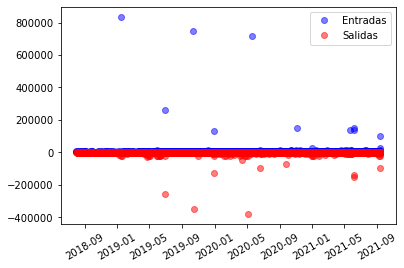

In [13]:
df_pos = df[df['Cantidad'] > 0]
df_neg = df[df['Cantidad'] < 0]

plt.plot(df_pos['Creado en_fecha'], df_pos['Cantidad'], 'go', label='Entradas', alpha=0.5, color='blue')
plt.plot(df_neg['Creado en_fecha'], df_neg['Cantidad'], 'go', label='Salidas', alpha=0.5, color='red')
plt.tick_params(axis='x', labelrotation=30)
plt.legend()
plt.show()

Se muestran los datos de un solo producto para el análisis.

Al revisar los gráficos de entradas y salidas, se notan demasiados valores porque existe demasiado movimiento diario.  Se decidió agrupar todos los movimientos diarios por mes.


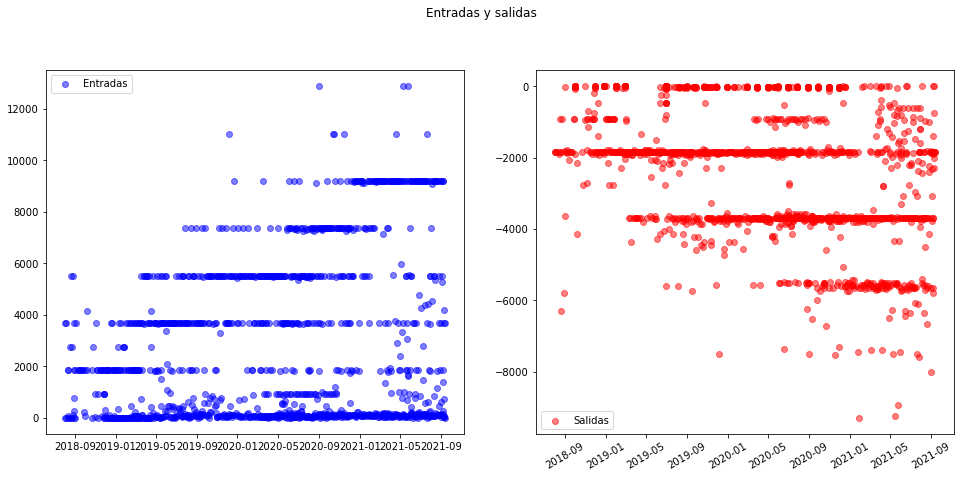

In [14]:
df_pos = df_pos[df_pos["Producto/Nombre"] == 'Producto base 1'] 
df_neg = df_neg[df_neg["Producto/Nombre"] == 'Producto base 1'] 

_, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize=(14,7))


ax1.scatter(df_pos['Creado en_fecha'], df_pos['Cantidad'], label='Entradas', alpha=0.5, color='blue')
ax1.legend(loc='best')

ax2.scatter(df_neg['Creado en_fecha'], df_neg['Cantidad'], label='Salidas', alpha=0.5, color='red')
ax2.legend(loc='best')

plt.tick_params(axis='x', labelrotation=30)
plt.suptitle(r'Entradas y salidas')
plt.tight_layout(pad=3.0)
plt.show()

Se remueve la columna que habíamos usado para la visualización y se continúa con el proceso de análisis de datos.

In [15]:
df.drop(columns=['Creado en_fecha'], inplace=True)

### Limpiar datos y manejar tipos de datos
Consiste en eliminar columnas que no se van a usar.  Además cambiar la colummna _Creado en_ para que tenga el tipo de datos que se ocupa.

También, se redondea los valores en la columna _Cantidad_ y se eliminan las filas donde la _Cantidad_ sea cero, pues significa que no hubo movimiento en el inventario.

In [16]:
# Se eliminan columnas innecesarias: Cantidad restante,Categoría de producto/Nombre mostrado, 
# Movimiento stock/Ubicación origen/Nombre ubicación, Movimiento stock/Ubicación destino/Nombre ubicación

df.drop(columns=["Cantidad restante", "Categoría de producto/Nombre mostrado", 
                 "Movimiento stock/Ubicación origen/Nombre ubicación",
                 "Movimiento stock/Ubicación origen/Nombre mostrado",
                 "Movimiento stock/Ubicación destino/Nombre mostrado",
                 "Movimiento stock/Ubicación destino/Nombre ubicación"], inplace=True)
print('Columnas restantes:', df.columns)

# Solo nos interesa el año y el mes
df['Creado en'] = pd.to_datetime(df['Creado en'].str.slice(0,7), format="%Y-%m", errors='ignore')


# Redondeo de columnas a 4 decimales e eliminiacion de los 0
df = df.round({"Cantidad": 4})
df = df[df["Cantidad"] != 0]

# Quitando datos del último mes de los datos, pues no están los datos completos
df = df[df['Creado en'] < pd.Timestamp(2021, 9, 1)]

df.describe()

Columnas restantes: Index(['Producto/Nombre', 'Cantidad', 'Creado en',
       'Categoría de producto/Nombre completo'],
      dtype='object')


,Cantidad
count,14487.000000
mean,10.375428
std,13052.848180
min,-383000.000000
25%,-230.000000
50%,-7.000000
75%,15.000000
max,836270.000000


### Manejo de Entradas y Salidas de inventario

Se separa el dataset en 2 para su análisis: Las cantidades positivas son _Entradas_ y negativas son _Salidas_.

Las _Salidas_ se pasan a positivo para su respectivo análisis.

In [17]:
# Se separan el dataset en 2
df_in_pr, df_out_pr = agruparCantidadPorProducto(df)
# Salidas a cantidades positivas
df_out_pr['Cantidad'] = df_out_pr['Cantidad'] * -1
df_in_pr

,Creado en,Producto/Nombre,Cantidad
0,2018-08-01,Producto base 5,36011.160
1,2018-09-01,Producto base 5,42020.590
2,2018-10-01,Producto base 5,18000.000
3,2018-11-01,Producto base 5,42000.000
4,2018-12-01,Producto base 5,24000.000
...,...,...,...
323,2021-04-01,Producto base 1,166707.000
324,2021-05-01,Producto base 1,135650.275
325,2021-06-01,Producto base 1,147469.000
326,2021-07-01,Producto base 1,145354.000


Visualización de las entradas por producto al inventario.

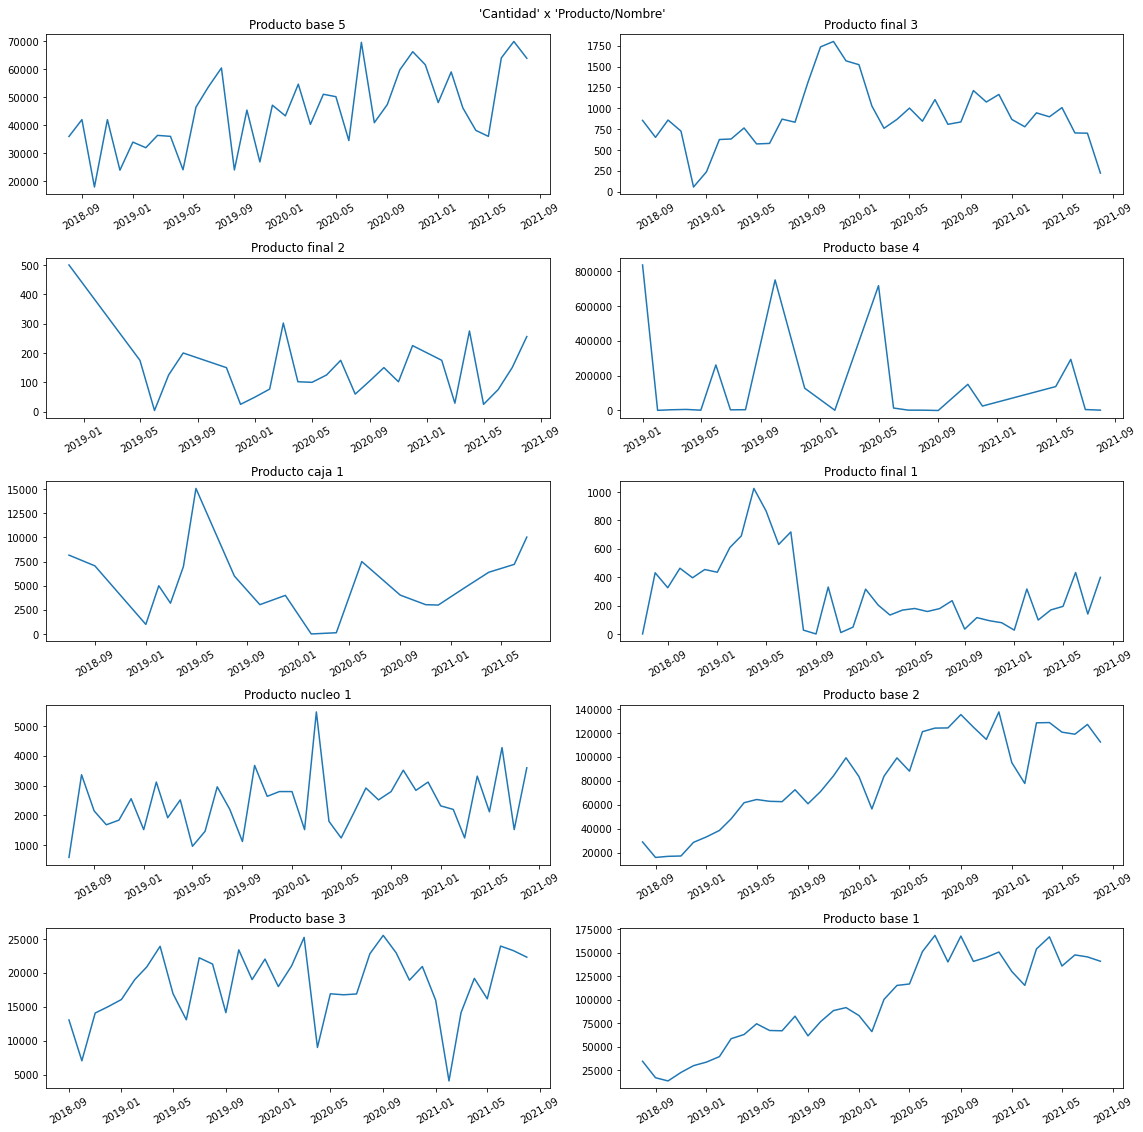

In [18]:
graficarPorCat(df_in_pr, "Producto/Nombre", "Creado en", "Cantidad")

## Análisis de datos

### Análisis de las entradas de un producto 

Se inicia con el análisis de un solo producto, cuyo nombre es _Producto base 1_.

Train Score: 0.02 MSE (0.11 MAE)
Test Score: 0.02 MSE (0.11 MAE)


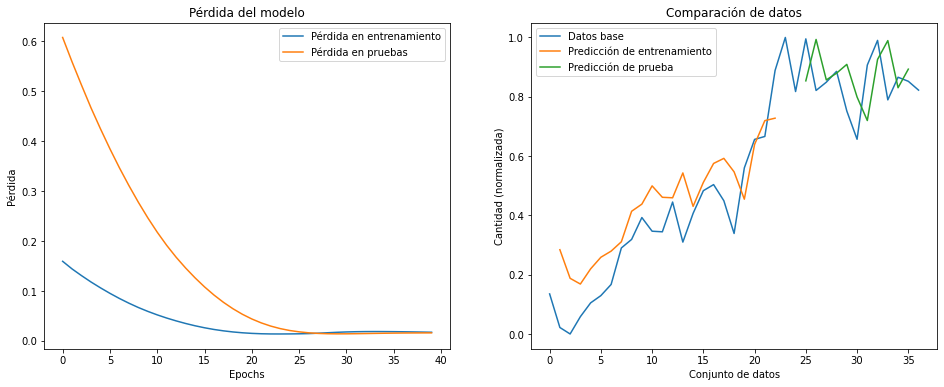

In [19]:
train_analyze(df_in_pr, 'Producto base 1')

Train Score: 0.05 MSE (0.18 MAE)
Test Score: 0.05 MSE (0.18 MAE)


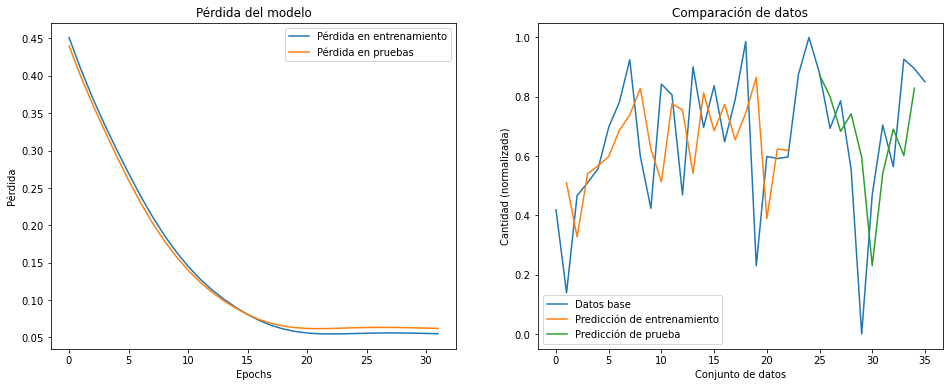

In [20]:
train_analyze(df_out_pr, 'Producto base 3')

### Análisis de las salidas de un producto 
Continuando con el análisis anterior, se procede esta vez a analizar las salidas del producto cuyo nombre es _Producto base 1_.

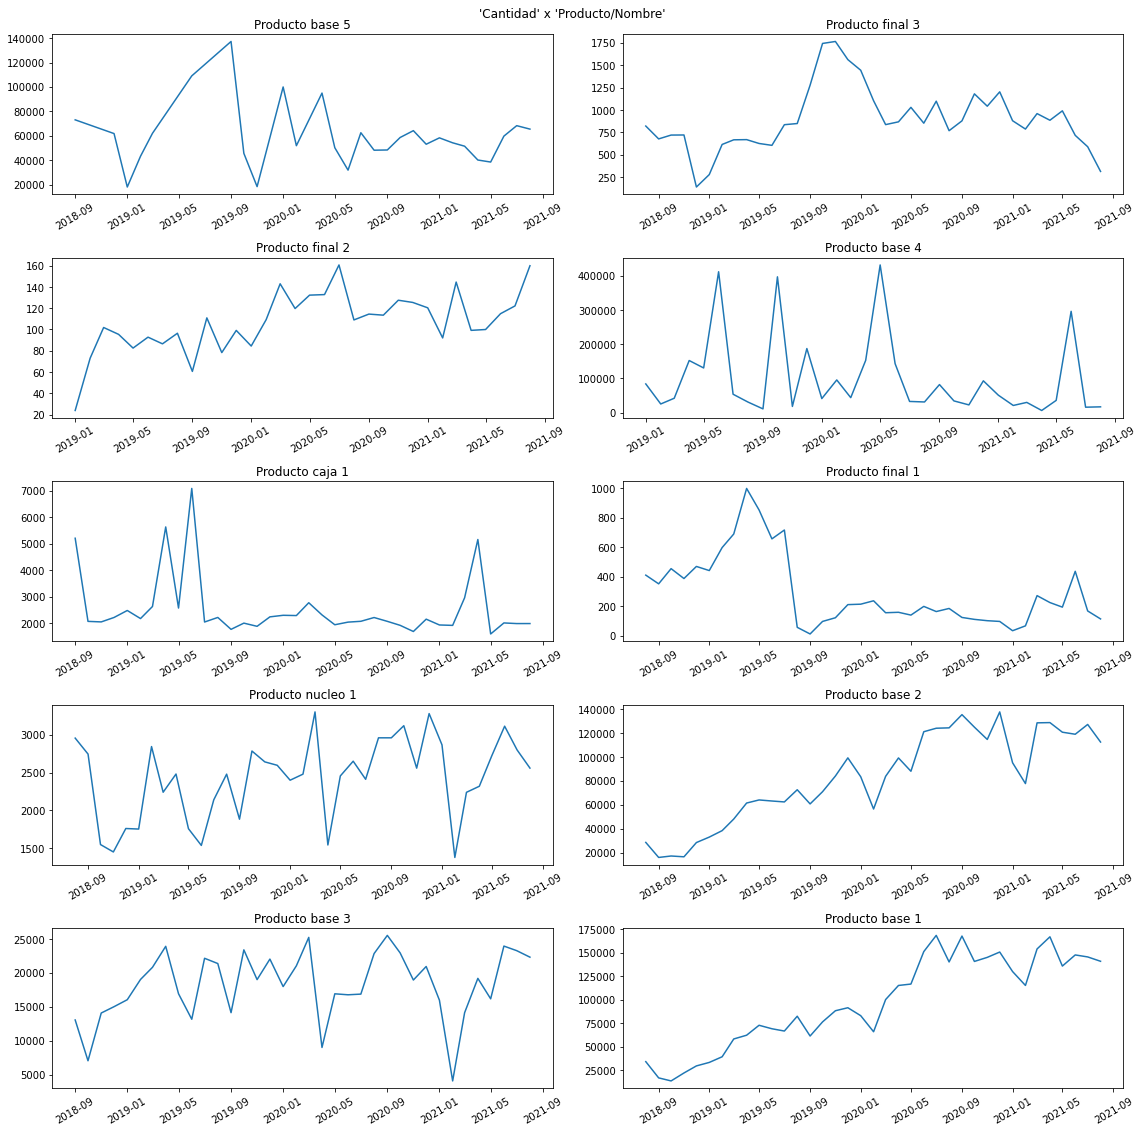

In [21]:
graficarPorCat(df_out_pr, "Producto/Nombre", "Creado en", "Cantidad")

Train Score: 0.01 MSE (0.09 MAE)
Test Score: 0.01 MSE (0.09 MAE)


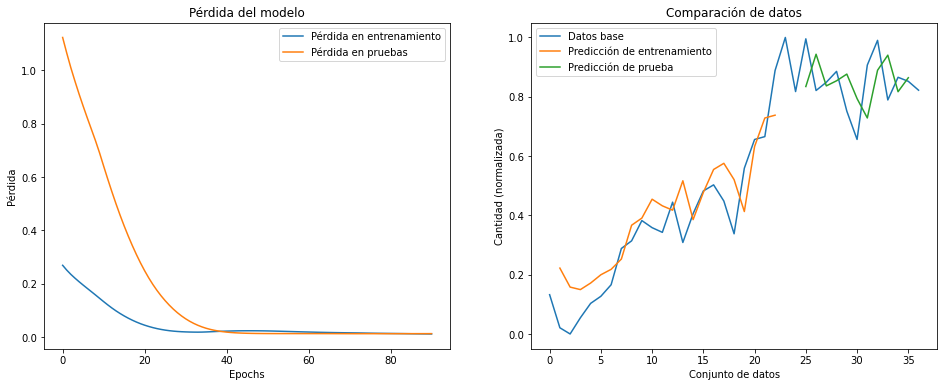

In [22]:
train_analyze(df_out_pr, 'Producto base 1')

Train Score: 0.05 MSE (0.18 MAE)
Test Score: 0.05 MSE (0.18 MAE)


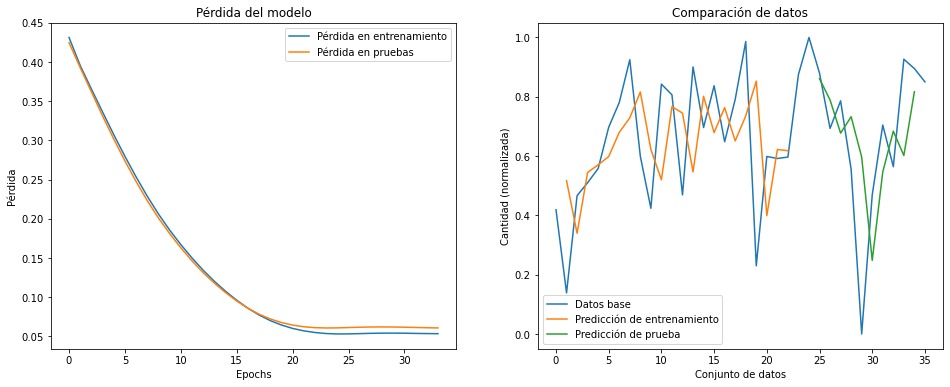

In [23]:
train_analyze(df_out_pr, 'Producto base 3')

trainX (246, 11) trainY (246,)
testX (82, 11) testY (82,)
Train Score: 0.00 MSE (0.02 MAE)
Test Score: 0.00 MSE (0.02 MAE)


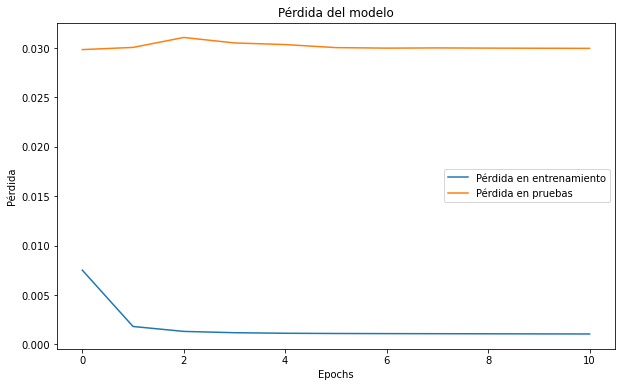

In [24]:
## X = Cantidad en el tiempo T, productos (one-hot-encoding)
## Y = Cantidad en el tiempo T+1
def train_analyze_whole_dataframe(df):
    
    # one-hot-encoding para los productos
    df2 = pd.get_dummies(df, columns=['Producto/Nombre'], prefix='pr')
    df2.drop(columns=['Creado en'], inplace=True)
    
    # normalización de las cantidades
    df2['Cantidad'] = MinMaxScaler().fit_transform(np.array(df2['Cantidad']).reshape(-1,1))
    
    # calculando: Y = Cantidad en el tiempo T+1
    primerRecord = df2.loc[0].copy()
    tMas1 = df2[1:len(df)]
    tMas1 = tMas1.append(primerRecord, ignore_index=True)
    
    # dividir entrenamiento y pruebas
    trainX, testX, trainY, testY = train_test_split(df2, tMas1['Cantidad'], random_state=13)
    
    print('trainX', trainX.shape, 'trainY', trainY.shape)
    print('testX', testX.shape, 'testY', testY.shape)
    
    # definición y entrenamiento de la red nueronal
    model, history = neural_model(trainX.shape[1], trainX, trainY, testX, testY, 300, 20)
    
    # evaluaciones
    trainScore = model.evaluate(trainX, trainY, verbose=0)
    print('Train Score: %.2f MSE (%.2f MAE)' % (trainScore[0], trainScore[1]))

    testScore = model.evaluate(testX, testY, verbose=0)
    print('Test Score: %.2f MSE (%.2f MAE)' % (trainScore[0], trainScore[1]))
    
    # graficar errores de datos predecidos contra los originales
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)
    
    # grafica los resultados
    fig, ax1 = plt.subplots(1, 1, figsize=(10,6))
    ax1.plot(history.history['loss'], label='Pérdida en entrenamiento')
    ax1.plot(history.history['val_loss'], label='Pérdida en pruebas')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Pérdida')
    ax1.set_title('Pérdida del modelo')
    ax1.legend()
    plt.show()

dfout = train_analyze_whole_dataframe(df_in_pr)

## Trabajo futuro
- Experimentar con el hiperparámetro del porcentaje de los datos de entrenamiento.  En ese documento se usan el 67% como entrenamiento y 33% de pruebas. Aunque es más bajo del 80-20 visto en clase, da muy buenos resultados.
- Uso de escogencia aleatoria en lugar de partir el conjunto de datos en dos.
- Probar con diferentes funciones de activación. Las capas intermedias se activan con Rectified Linear Unit (relu).

## Conclusiones
1. Las series de tiempo se manejan diferente, para lograr predicciones los que normalmente **se usaría como Y** (target), columna **_Cantidad_** en nuestro caso, se deja como parte de X, y **la _Cantidad_ en el tiempo+1** es lo que **se usa como Y**. - Referirse a función _convert2matrix_.
1. Otra diferencia es la escogencia de los datos de entrenamiento y de prueba, pues en lugar de hacer una escogencia aleatoria se toma el primer _p_ porciento de los datos como entrenamiento y _1-p_ como pruebas.  En contraste con los datos aleatorios que vimos en clase para los otros casos.
1. Definitivamente, redes neuronales es un excelente método de predicción para series de tiempo.
1. En nuestro caso, los datos contenían la información de entradas y salidas de varios productos. Hacer el análisis por cada producto por aparte dio, por mucho, mejores resultados.